# Human Tumors: single cell PCHA

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from py_pcha import PCHA
from sklearn.utils import shuffle
from matplotlib.colors import CenteredNorm

In [3]:
adata = sc.read_h5ad('../../out/human-tumors/adata_dk_01.h5ad')

## MAGIC

In [4]:
import magic
# import pandas as pd
# import matplotlib.pyplot as plt
magic_operator = magic.MAGIC(solver='approximate')
X_magic = magic_operator.fit_transform(adata)


Calculating MAGIC...
  Running MAGIC on 1618 cells and 13938 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.30 seconds.
    Calculating affinities...
    Calculated affinities in 0.26 seconds.
  Calculated graph and diffusion operator in 1.35 seconds.
  Calculating imputation...
Calculated MAGIC in 1.63 seconds.


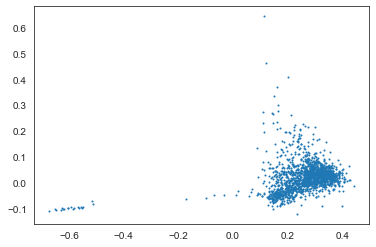

In [5]:
plt.scatter(X_magic.obs_vector('ASCL1'), X_magic.obs_vector('NEUROD2'),  s=1, cmap='inferno')


In [6]:
sc.pp.pca(X_magic)

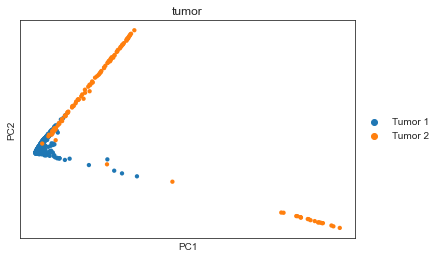

In [8]:
sc.pl.pca(X_magic, color='tumor')

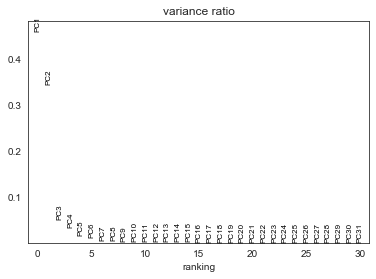

In [9]:
sc.pl.pca_variance_ratio(X_magic)

In [10]:
pca_var = X_magic.uns['pca']['variance_ratio']
var_explained = .85
tot_exp_var = 0
n = 0
for i in pca_var:
    n +=1
    tot_exp_var += i
    if tot_exp_var > var_explained: 
        print(n+1, "PCs explain at least", var_explained*100, "percent of the variance")
        break

4 PCs explain at least 85.0 percent of the variance


In [11]:
def cumulative(var):
    cum_var = []
    tot_sum = 0
    for i in var:
        tot_sum += i
        cum_var.append(tot_sum)
    return cum_var


In [12]:
cum_var = cumulative(pca_var)
cum_var[7]

0.927593310829252

In [13]:
def find_knee_varexpl(cum_var):
    farthestk = 0
    for i in range(50):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([0,cum_var[0]])
        p2=np.array([49,cum_var[49]])
        p3=np.array([i,cum_var[i]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    return knee +1 # number of components is 1 more than index
print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

Knee of EV vs PC plot:  6


In [14]:
X_magic.write_h5ad('../../out/human-tumors/X_magic_02.h5ad')

## PCHA 

In [147]:
!pip install py_pcha

In [16]:
X_magic = sc.read_h5ad('../../out/human-tumors/X_magic_02.h5ad')

In [17]:
def find_knee(ev_per_arc, kmax):
    farthestk = 0
    for i in range(3,kmax):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([3,ev_per_arc[0]])
        p2=np.array([kmax,ev_per_arc[kmax-3]])
        p3=np.array([i,ev_per_arc[i-3]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    print("K* =",knee, "archetypes, distance between k* and line: ",np.round(farthestk,2))
    return knee, farthestk

# PCHA on data without doublets

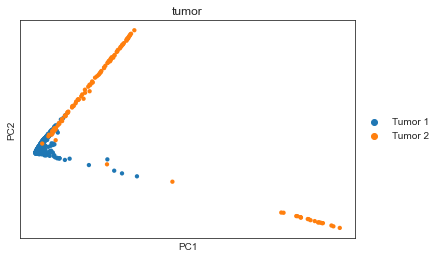

In [18]:
sc.pl.pca(X_magic, color='tumor')

In [507]:
# pca_var = X_magic_no_doublets.uns['pca']['variance_ratio']
# cum_var = cumulative(pca_var)

# print("Knee of EV vs PC plot: ",find_knee_varexpl(cum_var))

Knee in EV vs k plot for different k_max:
k_max = 8
K* = 6 archetypes, distance between k* and line:  0.05
k_max = 9
K* = 6 archetypes, distance between k* and line:  0.05
k_max = 10
K* = 6 archetypes, distance between k* and line:  0.06


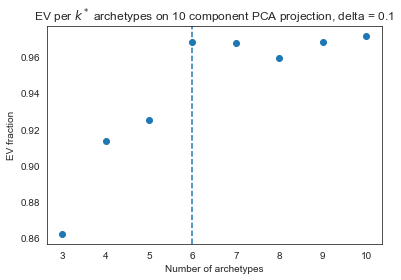

In [19]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:10].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    # print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 10 component PCA projection, delta = 0.1")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.show()

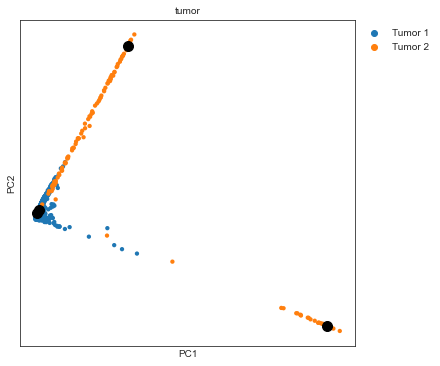

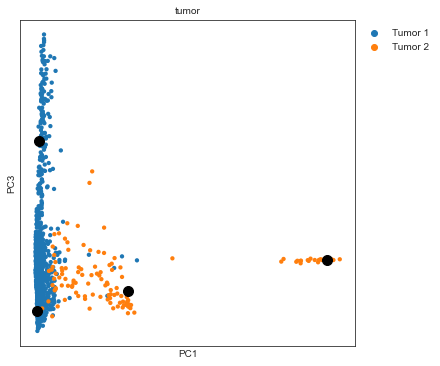

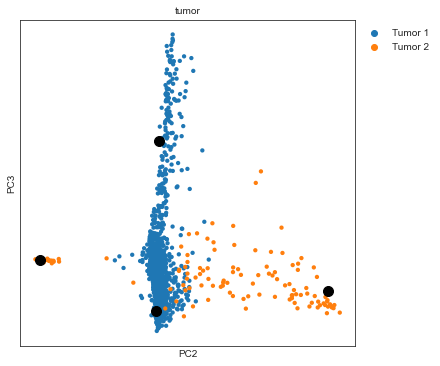

In [22]:
XC_4_6comp, S, C, SSE, varexpl = PCHA(X_magic.obsm['X_pca'][:,0:6].T, noc=4, delta=0)
XC_4_6comp = np.array(XC_4_6comp)
for components in ['1,2','1,3','2,3']:
    scv.pl.pca(X_magic, color = 'tumor', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC_4_6comp[int(comp[0])-1], XC_4_6comp[int(comp[1])-1], color = 'k', s = 100)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [23]:
XC_df = pd.DataFrame(XC_4_6comp)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4']


In [24]:
X_magic_pca_df = pd.DataFrame(X_magic.obsm['X_pca'][:,0:6], index = X_magic.obs_names)
X_magic_full_df = X_magic_pca_df.append(XC_df.T)
X_magic_full_df.head()

,0,1,2,3,4,5
/scratch/h_vangard_1/daix4/Ken/20200121_indropv2_human_dropEst/velocyto_result/236D_236D_V300044428:AAAACTCGAGAGTTCAC-Tumor 1,-2.766823,-2.857215,-0.186106,4.047020,-0.943995,-0.682483
/scratch/h_vangard_1/daix4/Ken/20200121_indropv2_human_dropEst/velocyto_result/236D_236D_V300044428:AAAACTCGATGTGCTCA-Tumor 1,-2.897242,-3.289501,-0.511147,4.299167,-0.289713,-1.972911
/scratch/h_vangard_1/daix4/Ken/20200121_indropv2_human_dropEst/velocyto_result/236D_236D_V300044428:AAAACTCGAAGGCAGTT-Tumor 1,-1.869769,-2.130676,0.477493,2.320273,-0.332569,0.181070
/scratch/h_vangard_1/daix4/Ken/20200121_indropv2_human_dropEst/velocyto_result/236D_236D_V300044428:AAAACTCGAACATCTAT-Tumor 1,-1.807501,-0.603380,-0.007683,0.592532,-1.321284,0.785172
/scratch/h_vangard_1/daix4/Ken/20200121_indropv2_human_dropEst/velocyto_result/236D_236D_V300044428:AAAACGCCTTGTTTGAG-Tumor 1,-1.222721,0.761947,7.072867,-2.510801,0.172091,0.217904


In [25]:
pdx = squareform(pdist(X_magic_full_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=X_magic_full_df.index, columns=X_magic_full_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
X_magic.obsm['arc_distance'] = pdx_df.T

Now that we have a euclidean distance to each archetype on the MAGIC imputed data, we can find a neighborhood with arbritrary radius to classify cells closest to each archetype as specialists. In Van Dijk et al., they choose a radius (distance on diffusion map) that is 1/2 the minimum of the distance between archetypes.

In [26]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [27]:
tmp = X_magic.obsm['arc_distance'].copy()

In [28]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  X_magic.obsm['arc_distance'].columns:
    closest = X_magic.obsm['arc_distance'].loc[X_magic.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [29]:
X_magic.obs['specialists_pca_diffdist'] = tmp.specialist

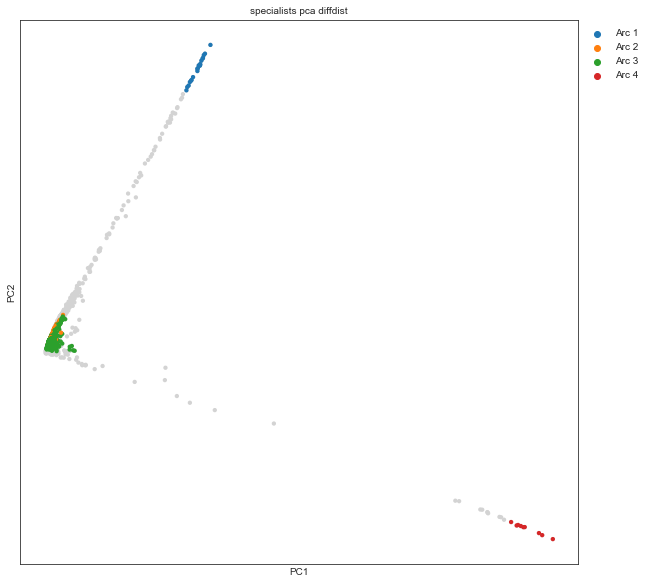

In [30]:
scv.pl.pca(X_magic, color = 'specialists_pca_diffdist', figsize= (10,10), frameon=True)


In [31]:
tmp.specialist = tmp.specialist.fillna('None')


In [33]:
pd.crosstab(tmp.specialist, X_magic.obs.tumor)

tumor,Tumor 1,Tumor 2
specialist,,
Arc_1,0,20
Arc_2,71,0
Arc_3,932,1
Arc_4,0,9
None,494,91


In [524]:
list_idx = []
list_type = []
list_train = []
for i in pdx_df.index:
    tmp_sort = pdx_df.T.sort_values(i).iloc[0:int(.01*len(pdx_df.columns))]
    tmp_list = tmp_sort.index
    for f in tmp_list:
        list_idx.append(f)
        list_type.append(i)
    tmp_arr = np.array(X_magic_pca_df.loc[tmp_list])
    list_train.append(tmp_arr)

In [525]:
import phenograph
test = X_magic_pca_df.copy().drop(list_idx)
# crazy reshaping necessary because phenograph classify requires a list of arrays, one array per subtype
# c, P = phenograph.classify(train=[np.reshape(examples, (1, -1)) for examples in np.array(arc_pca_df.drop('color',axis = 1))], test = magic_pca_df)
c, P = phenograph.classify(train=list_train, test = test)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm


In [526]:
test_adata = X_magic_no_doublets[test.index].copy()

In [534]:
P[:,1].shape

(13389,)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

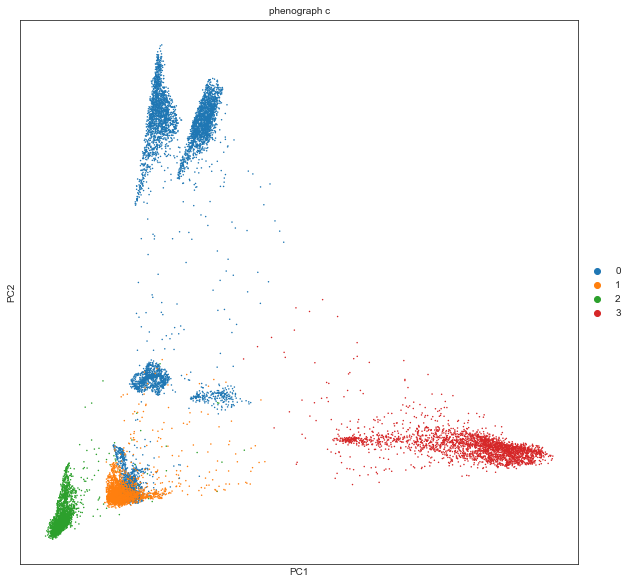

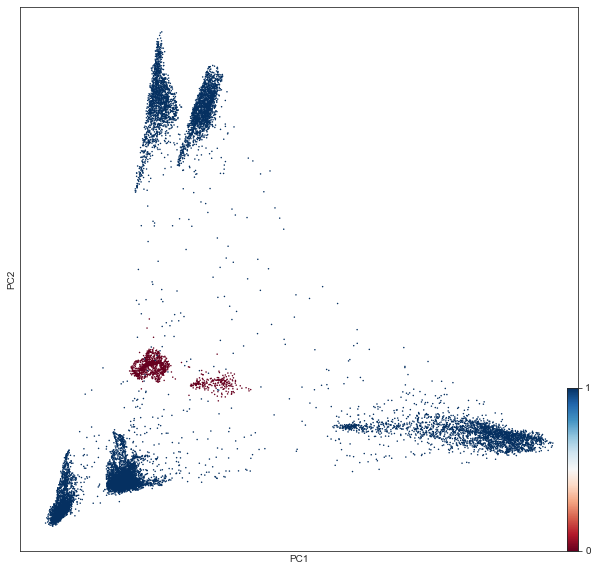

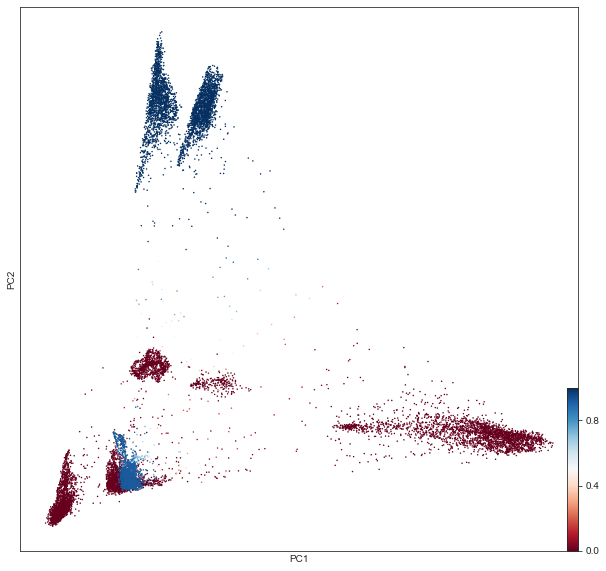

In [536]:
test_adata.obs['phenograph_c'] = c
test_adata.obsm['phenograph_P'] = P
scv.pl.pca(test_adata, c = 'phenograph_c', components='1,2', show=False, figsize= (10,10), frameon=True,  legend_loc = 'on right')

scv.pl.pca(test_adata, c = P.sum(axis = 1), components='1,2', show=False, figsize= (10,10), frameon=True, cmap = 'RdBu')
scv.pl.pca(test_adata, c = P[:,0], components='1,2', show=False, figsize= (10,10), frameon=True, cmap = 'RdBu')


## Labeling by PCHA

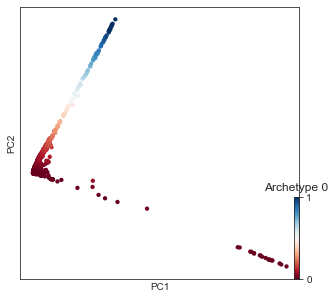

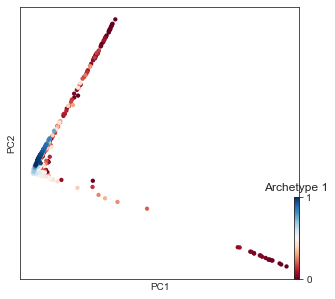

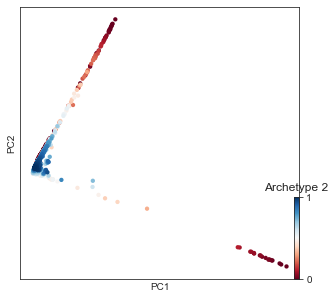

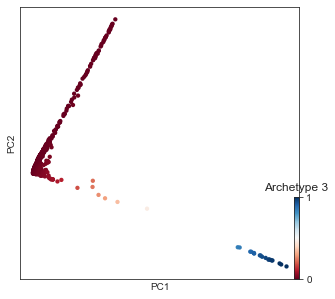

In [34]:
for i in range(4):
    scv.pl.pca(X_magic, c = S[i,:].T, components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu')
    plt.title(f"Archetype {i}")
    plt.savefig(f'../../figures/ParetoTI/human-tumors/{i}_scPCHA_pca.pdf')

In [35]:
S_df = pd.DataFrame(S.T)

In [36]:
S_df.index = X_magic.obs_names

In [43]:
S_df['tumor'] = [i.split('-')[-1] for i in S_df.index]

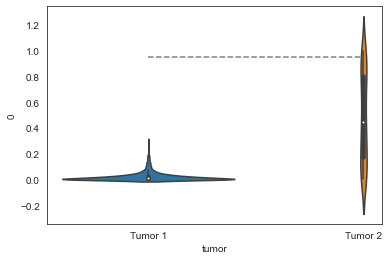

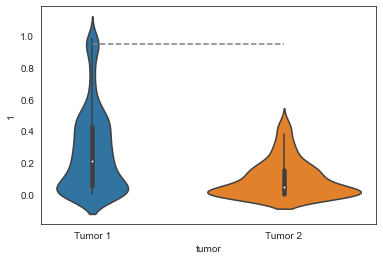

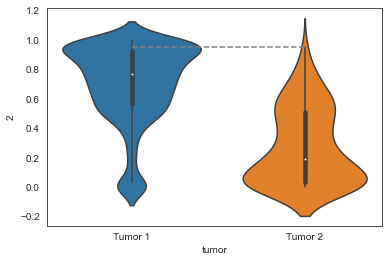

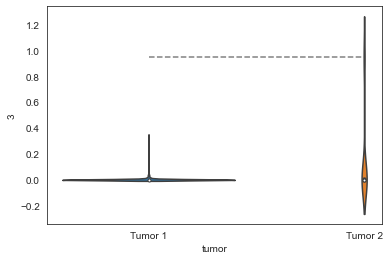

In [44]:
for i in range(4):
    sns.violinplot(data = S_df, x = 'tumor', y = S_df[i])
    plt.hlines(y = .95, xmin = 0, xmax = 1, linestyles='--', color = 'grey')
    plt.savefig(f'../../figures/ParetoTI/human-tumors/{i}_scPCHA_labels.pdf')
    plt.show()


In [45]:
for i in range(4):
    print(S_df.groupby('tumor')[i].apply(lambda c: (c>0.95).sum()/len(c)))

tumor
Tumor 1    0.000000
Tumor 2    0.115702
Name: 0, dtype: float64
tumor
Tumor 1    0.035404
Tumor 2    0.000000
Name: 1, dtype: float64
tumor
Tumor 1    0.186373
Tumor 2    0.000000
Name: 2, dtype: float64
tumor
Tumor 1    0.00000
Tumor 2    0.07438
Name: 3, dtype: float64


# Write out data

In [46]:
adata.write_h5ad('../../out/human-tumors/adata_02.h5ad')

In [47]:
X_magic.write_h5ad("../../out/human-tumors/X_magic_02.h5ad")

## Write out data for ParetoTI 
T ratio calculation and comparison of single cell archetypes to bulk archetypes using enrichments


We will run archetype analysis using ParetoTI, and compare the single cell and bulk archetypes using the Hausser code (hypergeometric tests on enrichments). We will use the PCA of the MAGIC imputed data.

In [48]:
X_magic_for_R = X_magic.copy()

In [49]:
X_magic_for_R

AnnData object with n_obs × n_vars = 1618 × 13938
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'PTPRC+', 'COL1A1+', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-Tumor 1', 'dropkick_coef-Tumor 2', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'n_cells'
    uns: 'pca', 'tumor_colors', 'specialists_pca_diffdist_colors'
    obsm: 'X_pca', 'arc_distance'
    varm: 'PCs'

In [50]:
#Get rid of arc_distance, which causes a problem in R
X_magic_for_R.obsm = {'X_pca':X_magic_for_R.obsm['X_pca']}

In [51]:
for col in ['specialists_pca_diffdist']:
    X_magic_for_R.obs[col]=X_magic_for_R.obs[col].cat.add_categories("Unknown").fillna('Unknown')

In [52]:
X_magic_for_R.obs.isnull().values.any()

False

In [53]:
X_magic_for_R.write_h5ad("../../out/human-tumors/X_magic_for_R.h5ad")

# Projection of Single Cell Data into Bulk PCA

In [54]:
adata = sc.read_h5ad('../../out/human-tumors/adata_02.h5ad')

In [55]:
X_magic = sc.read_h5ad('../../out/human-tumors/X_magic_02.h5ad')

We read in the cell lines, rescale, and run a PCA (which mean-center the data). N.B. the archetype location gene lists got messed up from Excel dates, so we remove the genes that no longer match.

In [56]:
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
def fit_bulk_pca(adata_var_names):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    # bulk = bulk / np.linalg.norm(bulk, axis=0)

    pca = PCA(n_components=20)
    data_pca = pca.fit_transform(bulk.T)
    pca_df = pd.DataFrame(data_pca)
    
    arc = pd.read_csv('../../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
    arc_genes = pd.read_csv('../../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
    arc.columns = arc_genes[0]
    arc = arc.T
    arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']
    arc = arc.loc[shared_genes]
    arc = pd.DataFrame(pp.scale(arc), columns = arc.columns, index = arc.index)

    # arc = arc / np.linalg.norm(arc, axis=0)

    arc_pca = pca.transform(arc.T)
    arc_pca_df = pd.DataFrame(arc_pca, index=arc.columns)
    arc_pca_df['color'] = arc.columns
    
    return pca, pca_df, arc_pca_df, shared_genes

## Projection of Original Single Cell Data
We compare the original (filtered, normalized, log-transformed) single cell data directly to the bulk archetypes by transforming with the same PCA.

In [57]:
pca, pca_df, arc_pca_df, shared_genes = fit_bulk_pca(adata.var_names)

In [58]:
def transform_data(adata, pca, shared_genes, layer = 'X'):
    tmp = adata[:,shared_genes].copy()
    if layer == 'X':
        adata_df = pd.DataFrame(tmp.X, index=tmp.obs_names, columns=tmp.var_names)
    else:
        adata_df = pd.DataFrame(tmp.layers[layer].todense(), index=tmp.obs_names, columns=tmp.var_names)

    adata_df = adata_df.T
    adata_df = pd.DataFrame(pp.scale(adata_df), columns = adata_df.columns, index = adata_df.index)

    # adata_df = adata_df / np.linalg.norm(adata_df, axis=0)

    adata_pca = pca.transform(adata_df.T)
    adata_pca_df = pd.DataFrame(adata_pca, index=adata_df.columns)
    tot_var_full = adata_df.T.var().sum()
    varexpl = adata_pca_df.var() #var explained by bulk PCA
    return adata_df, adata_pca_df, {'tot_var_full':tot_var_full, 'varexpl':varexpl}


In [59]:
adata_df, adata_pca_df, adata_var_dict = transform_data(adata, pca, shared_genes)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


<AxesSubplot:xlabel='0', ylabel='1'>

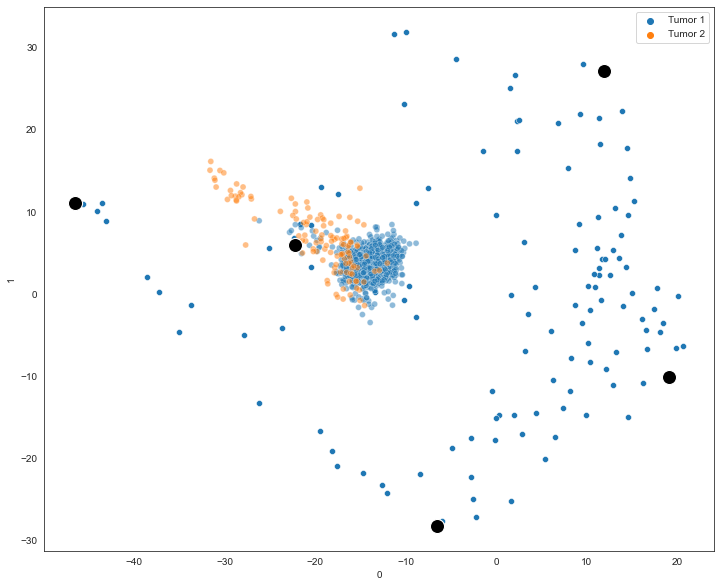

In [61]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1])
sns.scatterplot(-adata_pca_df[0], adata_pca_df[1], hue = adata.obs.tumor, alpha = .5)
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)

# sns.scatterplot(-adata_arc.loc[pcs_to_plot[0]],-adata_arc.loc[pcs_to_plot[1]], hue =  adata.obs['cline'])#adata.obs['cline'].values)
# sns.scatterplot(-sc_arc_genes_pc.loc[pcs_to_plot[0]],-sc_arc_genes_pc.loc[pcs_to_plot[1]], color = 'black')

# plt.figure(figsize = (12,10))
# sns.scatterplot(-adata_arc.loc[pcs_to_plot[0]],-adata_arc.loc[pcs_to_plot[1]], hue =  all_df['cluster'], 
#                 palette = [cp[0],cp[1],cp[2],cp[3],'grey',cp[4]])#adata.obs['cline'].values)
# sns.scatterplot(-sc_arc_genes_pc.loc[pcs_to_plot[0]],-sc_arc_genes_pc.loc[pcs_to_plot[1]], color = 'black')


# plt.show()
# plt.figure(figsize = (12,10))
# sns.scatterplot(-adata_arc.loc[pcs_to_plot[0]],-adata_arc.loc[pcs_to_plot[1]], hue =  adata.obs['Phenotype'].values,
#                palette = ['grey','lightgrey','red','orange','green','blue','purple'])#
# sns.scatterplot(-sc_arc_genes_pc.loc[pcs_to_plot[0]],-sc_arc_genes_pc.loc[pcs_to_plot[1]], color = 'black')


### Compare the variance explained to the variance explained by shuffled PCs.

In [62]:
def EV_shuffled_fit(adata_var_names, adata_df, n_components = 20, n_shuffles = 10):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    ev = []
    for i in range(n_shuffles):
        ran = shuffle(bulk)
        ran.index = bulk.index
        ran_pca = PCA(n_components=n_components)
        ran_data_pca = ran_pca.fit_transform(ran.T)
        ran_pca_df = pd.DataFrame(ran_data_pca)
        adata_pca_rand = ran_pca.transform(adata_df.T)
        adata_pca_rand_df = pd.DataFrame(adata_pca_rand, index=adata_df.columns)
        ev.append(list(adata_pca_rand_df.var()))

    return ev

In [63]:
adata_var_dict['shuffled_fit_EV'] = EV_shuffled_fit(adata.var_names, adata_df)

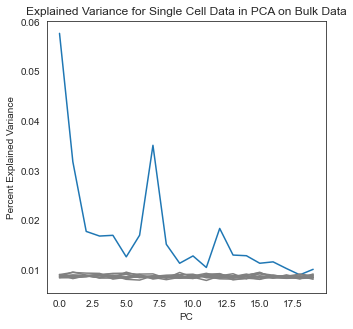

In [64]:
plt.figure(figsize = (5,5))
plt.plot(100*adata_var_dict['varexpl']/adata_var_dict['tot_var_full'])
for i in range(10):
    plt.plot([100*x for x in adata_var_dict['shuffled_fit_EV'][i]/adata_var_dict['tot_var_full']], c = 'grey')
plt.title('Explained Variance for Single Cell Data in PCA on Bulk Data')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

In [65]:
#ev_df for seaborn 
flat_list = [item for sublist in adata_var_dict['shuffled_fit_EV'] for item in sublist]
ev_df = pd.DataFrame(10*list(range(20)), columns=['PC'])
ev_df['ev'] = [100*i/adata_var_dict['tot_var_full'] for i in flat_list]

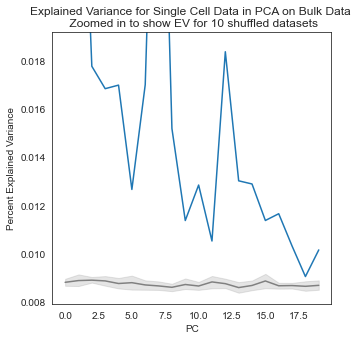

In [66]:
plt.figure(figsize = (5,5))
plt.plot(100*adata_var_dict['varexpl']/adata_var_dict['tot_var_full'])
# for i in range(10):
#     plt.plot([100*x for x in ev[i]], c = 'grey')
sns.lineplot(data = ev_df, x = 'PC', y = 'ev', color = 'grey')
plt.ylim(ev_df['ev'].min(),2*ev_df['ev'].max())
plt.title('Explained Variance for Single Cell Data in PCA on Bulk Data \n Zoomed in to show EV for 10 shuffled datasets')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

## Projection of MAGIC imputed data

### Fit single cell MAGIC data

In [67]:
magic_df, magic_pca_df, magic_var_dict = transform_data(X_magic, pca, shared_genes)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


<AxesSubplot:xlabel='0', ylabel='1'>

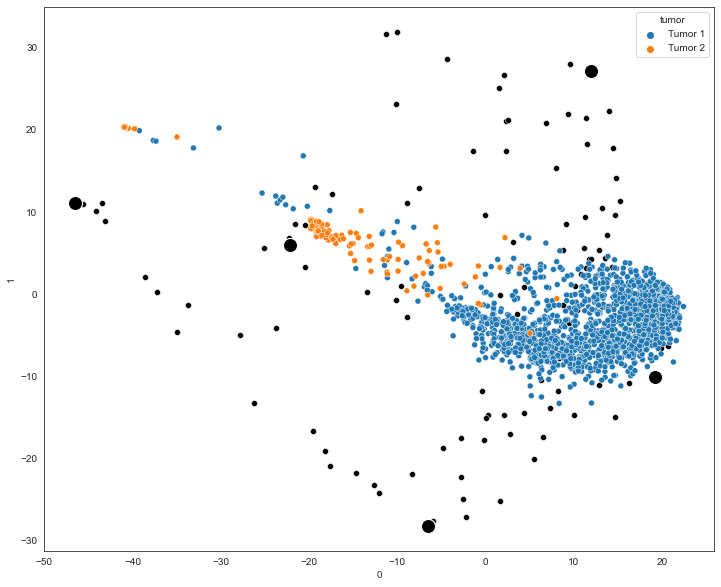

In [69]:

plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'k')
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
sns.scatterplot(-magic_pca_df[0], magic_pca_df[1], hue =  X_magic.obs['tumor'])


### Compare the variance explained to the variance explained by PCA fit to shuffled data.

Total variance in imputed and scaled single cell dataset:

In [70]:
magic_var_dict['shuffled_fit_EV'] = EV_shuffled_fit(X_magic.var_names, magic_df)

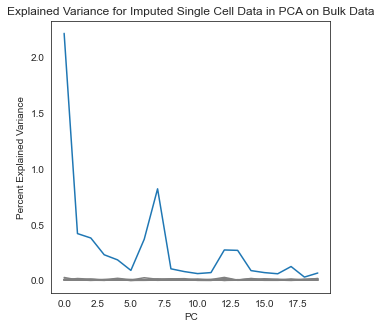

In [71]:
plt.figure(figsize = (5,5))
plt.plot(100*magic_var_dict['varexpl']/magic_var_dict['tot_var_full'])
for i in range(10):
    plt.plot([100*x for x in magic_var_dict['shuffled_fit_EV'][i]/magic_var_dict['tot_var_full']], c = 'grey')
plt.title('Explained Variance for Imputed Single Cell Data in PCA on Bulk Data')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

In [72]:
def pca_upperbound(adata_df, n_components=20):
    pca_sc = PCA(n_components=n_components)
    pca_sc_transformed = pca_sc.fit_transform(adata_df.T)
    pca_sc_transformed_df = pd.DataFrame(pca_sc_transformed, index=adata_df.columns)
    EV_adata_only = pca_sc_transformed_df.var()
    return EV_adata_only
magic_var_dict['EV_upperbound'] = pca_upperbound(magic_df)

In [73]:
def Cumulative(lists):
    cu_list = []
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return cu_list[1:]

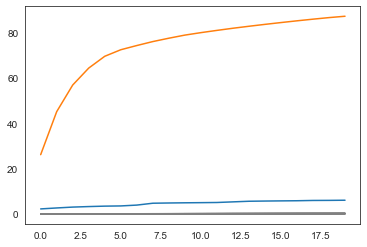

In [74]:
sns.lineplot(range(20),100*(Cumulative(magic_var_dict['varexpl'])/magic_var_dict['tot_var_full']))
sns.lineplot(range(20),100*(Cumulative(magic_var_dict['EV_upperbound'])/magic_var_dict['tot_var_full']))
for i in range(10):
    plt.plot([100*x for x in Cumulative(magic_var_dict['shuffled_fit_EV'][i])/magic_var_dict['tot_var_full']], c = 'grey')


<AxesSubplot:>

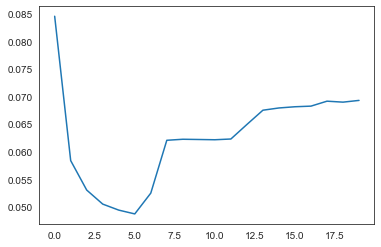

In [75]:
sns.lineplot(range(20),[i/j for i, j in zip(Cumulative(magic_var_dict['varexpl']),Cumulative(magic_var_dict['EV_upperbound']))])


### Compare the variance explained to the variance in shuffled data explained by PCA.

In [76]:
# Shuffling preserves total variance in data
shuffle(magic_df).T.var().sum()

5917.5273

In [77]:
def EV_shuffled_data(adata_var_names, adata_df, n_components = 20, n_shuffles = 10):
    bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
    bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]    
    shared_genes = sorted(list(set(adata_var_names).intersection(bulk.index)))
    bulk = bulk.loc[shared_genes]
    bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(bulk.T)
    pca_df = pd.DataFrame(data_pca)
    
    ev = []
    for i in range(n_shuffles):
        adata_pca_rand = pca.transform(shuffle(adata_df).T)
        adata_pca_rand_df = pd.DataFrame(adata_pca_rand, index=adata_df.columns)
        ev.append(list(adata_pca_rand_df.var()))

    return ev

In [78]:
magic_var_dict['shuffled_data_EV'] = EV_shuffled_data(X_magic.var_names, magic_df)

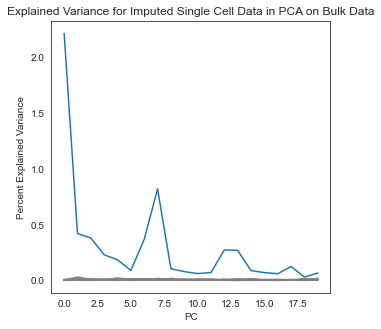

In [79]:
plt.figure(figsize = (5,5))
plt.plot(100*magic_var_dict['varexpl']/magic_var_dict['tot_var_full'])
for i in range(10):
    plt.plot([100*x for x in magic_var_dict['shuffled_data_EV'][i]/magic_var_dict['tot_var_full']], c = 'grey')
plt.title('Explained Variance for Imputed Single Cell Data in PCA on Bulk Data')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

In [80]:
#ev_df for seaborn 
flat_list = [item for sublist in magic_var_dict['shuffled_data_EV'] for item in sublist]
ev_df = pd.DataFrame(10*list(range(20)), columns=['PC'])
ev_df['ev'] = [100*i/magic_var_dict['tot_var_full'] for i in flat_list]

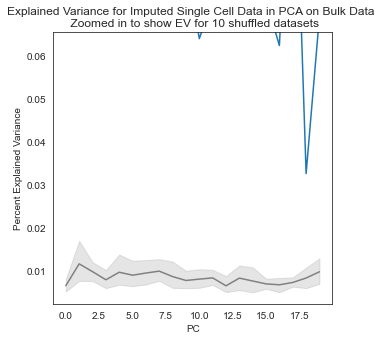

In [81]:
plt.figure(figsize = (5,5))
plt.plot(100*magic_var_dict['varexpl']/magic_var_dict['tot_var_full'])
# for i in range(10):
#     plt.plot([100*x for x in ev[i]], c = 'grey')
sns.lineplot(data = ev_df, x = 'PC', y = 'ev', color = 'grey')
plt.ylim(ev_df['ev'].min(),2*ev_df['ev'].max())
plt.title('Explained Variance for Imputed Single Cell Data in PCA on Bulk Data \n Zoomed in to show EV for 10 shuffled datasets')
plt.ylabel("Percent Explained Variance")
plt.xlabel("PC")
plt.show()

# Compare intra and inter-sample heterogeneity using Hausser code

**Comparing intra-tumor heterogeneity and inter-tumor diversity.**  (from Hausser et al.)
- To compare intratumor heterogeneity and intertumor diversity, we ﬁrst analyzed the single-cell gene expression using the Seurat package. Genes present in <5% of cells and outlier cells with <1500 or more than 8000 detectable genes were excluded from the analysis. 
- Gene expression data was normalized and scaled by the RNA count of each cell, the fraction of mitochondrial RNA, and the tumor of origin, as was done in the original study47. 
- After this ﬁltering, 650 single-cancer cells from six breast tumors were left for analysis. 
- We projected the single-cancer cells on the ﬁrst three principal components of metabric tumors5. *To do so, we focused on 1964 genes expressed in at least 50% of single-cancer cells and proﬁled in the metabric tumors, so that gene expression could be quantiﬁed in most cells, allowing projection of these cells on the space deﬁned by the ﬁrst three principal components of the metabric tumors.*
- To assess if intratumor heterogeneity and intertumor diversity are oriented in common directions of gene expression space, we computed the fraction of variance in gene expression explained by principal components computed on gene expression of metabric tumors. This fraction is necessarily bounded by the fraction of variance explained by principal components computed on gene expression from single cells. In other words, if intratumor heterogeneity and intertumor diversity were perfectly aligned in gene expression space, the fraction of variance explained by metabric principal components would equal the fraction of variance explained by single-cell principal components. 
- We used five PCs because of an elbow in the fraction of variance explained by single-cell PCs curve (Supplementary Fig. 4B).The first five metabric PCs explain 25.4 ± 3% of the variance explained by the first five single-cell PCs. This percentage is robust to using a different number of PCs(Supplementary Fig. 4C): varying the number of PCs from 5 to 50 keeps thepercentage in the 22–27% range. 
- To test if the fraction of variance explained by metabric PCs can be attributed to random structures in gene expression data, we shuffled the metabric gene expression by resampling expression of each gene. Doing so preserved the variance in the expression of each gene but destroyed correlations in the expression of different genes. The first five PCs of this shuffled dataset explain 1.5 ± 0.4% of the variance explained by single-cell PCs. A t-test supports the hypothesis that the first five metabric PCs explain significantly more variance in single cell gene expression than shuffled metabric PCs (p=0.0004, two-sided). Thus, intertumor diversity explains a significant fraction of intratumor heterogeneity.


## Measuring intra-sample heterogeneity

Tumor 1
7.549413094733372


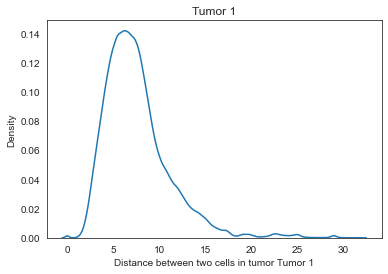

Tumor 2
35.408779638327346


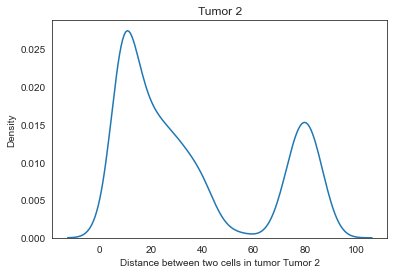

In [84]:
dist = squareform(pdist(X_magic.obsm['X_pca'], metric='euclidean')) # compute distances on pca
# ITH = pd.DataFrame(columns = ['distance','cline'])

dist_df = pd.DataFrame(dist, index = X_magic.obs_names,columns = X_magic.obs_names)

for i in (X_magic.obs.tumor.unique()):
    print(i)
    tmp_samples = X_magic[X_magic.obs.tumor == i].obs_names
    tmp_dist = dist_df.loc[tmp_samples, tmp_samples]
    print(np.average(np.array(tmp_dist)))
    # tmp_df = pd.concat([pd.Series(tmp_dist.mean()),pd.Series([i]*len(tmp_dist), index = tmp_dist.index)],ignore_index = True, axis = 1)
    # tmp_df.columns = ['distance','cline']
    # ITH = pd.concat([ITH, tmp_df])
    tmp_dist_stack = tmp_dist.stack()
    sns.kdeplot(tmp_dist_stack)
    plt.title(i)
    plt.xlabel(f'Distance between two cells in tumor {i}')
    plt.show()
    

In [39]:
!pip install statannot

## Using only highly variable genes

### HVGs

In [86]:
X_norm = sc.pp.normalize_total(adata, layer='raw_counts', inplace = False)['X']
adata.layers["norm_counts"] = X_norm


adata.layers['log1p_norm_unscaled'] = np.log1p(adata.layers["norm_counts"])


hvgs = sc.pp.highly_variable_genes(adata, layer='log1p_norm_unscaled', inplace=False)

hvgs.index = adata.var_names

In [87]:
pca, pca_df, arc_pca_df, shared_genes = fit_bulk_pca(hvgs.loc[hvgs.highly_variable==True].index)

In [88]:
bulk = pd.read_csv('../../../data/bulk-rna-seq/SCLC_combined_Minna_CCLE_batch_corrected_wo_lowgenes.csv', header = 0, index_col = 0)
bulk.head()

,m.DMS153,m.NCIH60,m.NCIH69,m.NCIH82,m.NCIH128,m.NCIH146,m.NCIH187,m.NCIH209,m.NCIH211,m.NCIH250,...,c.NCIH524,c.NCIH526,c.NCIH69,c.NCIH82,c.NCIH841,c.NCIH889,c.SBC5,c.SCLC21H,c.SHP77,c.SW1271
A1BG,2.955199,3.239727,3.599770,3.055231,4.579507,4.685081,3.215947,4.181752,1.288835,4.804468,...,4.183146,3.405942,4.256034,3.905371,4.436237,5.073359,4.423783,3.713345,3.438644,4.209637
A1CF,0.077212,0.167166,0.117398,0.536179,0.088160,0.074992,0.080727,0.079204,0.107217,0.090348,...,-0.057567,0.623162,-0.107734,-0.016782,0.183740,0.242981,0.008349,0.003494,-0.073834,-0.001700
A2M,2.267502,0.122302,0.085891,1.586479,0.064500,0.231189,0.059062,0.072303,0.189474,0.066101,...,-0.038265,-0.006552,0.040540,0.221331,1.276428,0.039852,0.681201,0.032354,1.635919,0.303402
A2ML1,0.011011,-0.007241,-0.005086,-0.004471,-0.003819,0.011107,-0.003497,-0.003431,-0.004644,-0.003914,...,0.003116,0.006167,0.006514,0.017533,0.015672,0.114451,0.043520,0.004658,0.003820,0.031692
A4GALT,2.453512,1.528297,1.428711,0.359365,0.865621,0.867495,2.455182,1.037618,0.265048,3.132071,...,0.569911,1.458448,0.513539,0.191663,3.127982,0.086832,2.641161,0.764500,0.861152,1.868799


In [89]:
bulk = bulk.loc[[i not in ['MARC1', 'MARC2', 'MARCH1', 'MARCH11', 'MARCH2', 'MARCH3', 'MARCH4', 'MARCH5', 'MARCH6', 'MARCH7', 'MARCH8', 'MARCH9', 'SEPT10', 'SEPT11', 'SEPT12', 'SEPT14', 'SEPT2', 'SEPT3', 'SEPT4', 'SEPT5', 'SEPT6', 'SEPT7', 'SEPT8', 'SEPT9'] for i in bulk.index]]

In [90]:
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA

shared_genes = sorted(list(set(hvgs.loc[hvgs.highly_variable==True].index).intersection(bulk.index)))
bulk = bulk.loc[shared_genes]
bulk = pd.DataFrame(pp.scale(bulk), columns = bulk.columns, index = bulk.index)
# bulk = bulk / np.linalg.norm(bulk, axis=0)

pca = PCA(n_components=20)
data_pca = pca.fit_transform(bulk.T)
pca_df = pd.DataFrame(data_pca)



We also read in the archetype locations and transform with the same PCA.

In [91]:
arc = pd.read_csv('../../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
arc_genes = pd.read_csv('../../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
arc.columns = arc_genes[0]
arc = arc.T
arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']


In [92]:
arc = arc.loc[shared_genes]
arc = pd.DataFrame(pp.scale(arc), columns = arc.columns, index = arc.index)

# arc = arc / np.linalg.norm(arc, axis=0)

arc_pca = pca.transform(arc.T)
arc_pca_df = pd.DataFrame(arc_pca, index=arc.columns)
arc_pca_df['color'] = arc.columns



In [93]:
tmp = adata[:,shared_genes].copy()
adata_df = pd.DataFrame(tmp.layers['log1p_norm_unscaled'].todense(), index=tmp.obs_names, columns=tmp.var_names)
adata_df = adata_df.T
adata_df = pd.DataFrame(pp.scale(adata_df), columns = adata_df.columns, index = adata_df.index)

# adata_df = adata_df / np.linalg.norm(adata_df, axis=0)

adata_pca = pca.transform(adata_df.T)


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


In [94]:
# number of hvgs
(hvgs.highly_variable == True).sum()


3272

### Fit to adata

In [95]:
adata_df_hvgs, adata_pca_df_hvgs, adata_var_dict_hvgs = transform_data(adata, pca, shared_genes, layer='log1p_norm_unscaled')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


<AxesSubplot:xlabel='0', ylabel='1'>

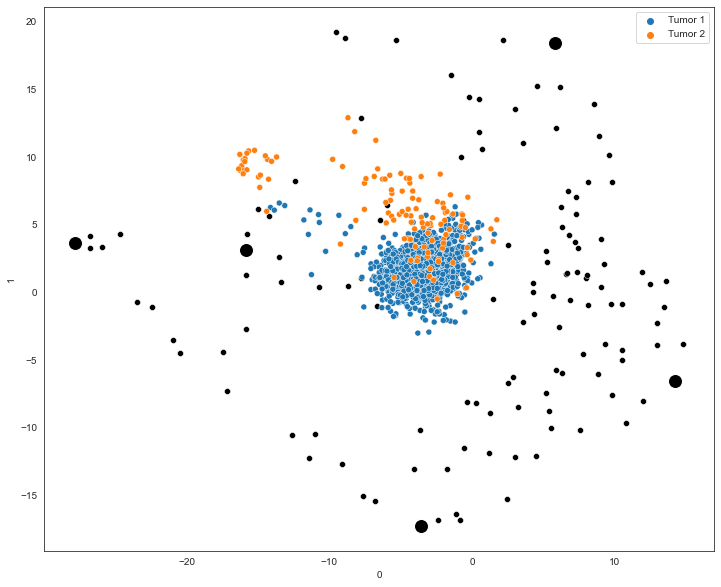

In [97]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'black')
sns.scatterplot(-adata_pca_df_hvgs[0], adata_pca_df_hvgs[1], hue =  X_magic.obs['tumor'])
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
# plt.savefig('../../figures/adata_pca_hvgs_in_arc_space.pdf')

In [98]:
n_shuffles = 50
adata_var_dict_hvgs['shuffled_fit_EV'] = EV_shuffled_fit(shared_genes, adata_df_hvgs, n_shuffles=n_shuffles)
adata_var_dict_hvgs['EV_upperbound'] = pca_upperbound(adata_df_hvgs)

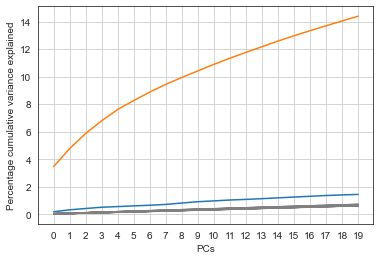

In [99]:
sns.lineplot(range(20),100*(Cumulative(adata_var_dict_hvgs['varexpl'])/adata_var_dict_hvgs['tot_var_full']))
sns.lineplot(range(20),100*(Cumulative(adata_var_dict_hvgs['EV_upperbound'])/adata_var_dict_hvgs['tot_var_full']))
for i in range(n_shuffles):
    plt.plot([100*x for x in Cumulative(adata_var_dict_hvgs['shuffled_fit_EV'][i])/adata_var_dict_hvgs['tot_var_full']], c = 'grey')
plt.xticks(range(20))
plt.grid()
plt.ylabel('Percentage cumulative variance explained')
plt.xlabel('PCs')
# plt.savefig('../../figures/adata_pca_hvgs_in_arc_space_EV.pdf')
plt.show()

In [100]:
# Variance explained in single cell data by single cell PCA
100*(Cumulative(adata_var_dict_hvgs['EV_upperbound'])/adata_var_dict_hvgs['tot_var_full'])[6]

8.876905201301787

In [101]:
# Variance explained in single cell data by bulk PCA
100*(Cumulative(adata_var_dict_hvgs['varexpl'])/adata_var_dict_hvgs['tot_var_full'])[6]

0.656864250215961

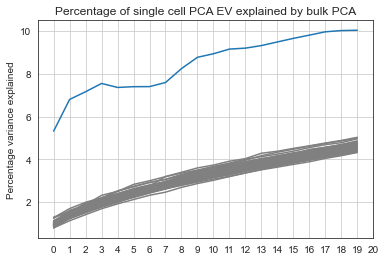

In [102]:
sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['varexpl']),Cumulative(adata_var_dict_hvgs['EV_upperbound']))])
for i in range(n_shuffles):
    sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['shuffled_fit_EV'][i]),Cumulative(adata_var_dict_hvgs['EV_upperbound']))],
                color = 'grey')
plt.xticks(range(21))
plt.grid()
plt.title('Percentage of single cell PCA EV explained by bulk PCA')
plt.ylabel('Percentage variance explained')
# plt.savefig('../../figures/adata_pca_hvgs_in_arc_space_EV_of_scEV.pdf')

plt.show()

In [103]:
#EV at 7 PCs
[i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['varexpl']),Cumulative(adata_var_dict_hvgs['EV_upperbound']))][6]

0.0739969882881742

In [104]:
# Average for different numbers of PCs
EV_ratios = [i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['varexpl']),Cumulative(adata_var_dict_hvgs['EV_upperbound']))]
np.average(EV_ratios)

0.08458749259955792

In [105]:
#SEM for EV
n_components = 20
np.std(EV_ratios)/np.sqrt(n_components)

0.0028740464518122013

In [106]:
random_ave_expl = []
for q in range(n_shuffles):
    random_ave_expl.append([i/j for i, j in zip(Cumulative(adata_var_dict_hvgs['shuffled_fit_EV'][q]),
                 Cumulative(adata_var_dict_hvgs['EV_upperbound']))][6])


In [107]:
np.average([100*i for i in random_ave_expl])

2.610358587224294

In [108]:
np.std([100*i for i in random_ave_expl])/np.sqrt(n_shuffles)

0.018214217727287735

### Fit to X_magic

In [109]:
magic_df_hvgs, magic_pca_df_hvgs, magic_var_dict_hvgs = transform_data(X_magic, pca, shared_genes)

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


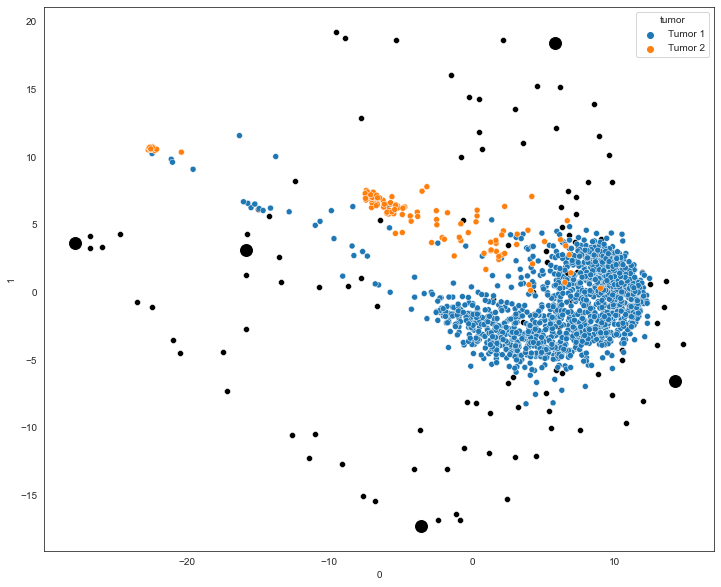

In [112]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'black')
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
sns.scatterplot(-magic_pca_df_hvgs[0], magic_pca_df_hvgs[1], hue =  X_magic.obs['tumor'])
plt.savefig('../../figures/human-tumors-magic_pca_hvgs_in_arc_space.pdf')

In [113]:
n_shuffles = 50
magic_var_dict_hvgs['shuffled_fit_EV'] = EV_shuffled_fit(shared_genes, magic_df_hvgs, n_shuffles=n_shuffles)
magic_var_dict_hvgs['EV_upperbound'] = pca_upperbound(magic_df_hvgs)

In [114]:
magic_var_dict['tot_var_full']

5917.527

In [115]:
magic_var_dict_hvgs['tot_var_full']

1647.4519

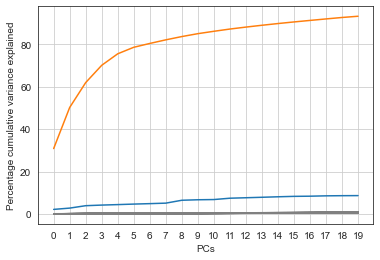

In [116]:
plt.figure(figsize = (6,4))
sns.lineplot(range(20),100*(Cumulative(magic_var_dict_hvgs['varexpl'])/magic_var_dict_hvgs['tot_var_full']))
sns.lineplot(range(20),100*(Cumulative(magic_var_dict_hvgs['EV_upperbound'])/magic_var_dict_hvgs['tot_var_full']))
for i in range(n_shuffles):
    plt.plot([100*x for x in Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][i])/magic_var_dict_hvgs['tot_var_full']], c = 'grey')
plt.xticks(range(20))
plt.grid()
plt.ylabel('Percentage cumulative variance explained')
plt.xlabel('PCs')
plt.savefig('../../figures/human-tumors-magic_pca_hvgs_in_arc_space_EV.pdf')

plt.show()


"We computed the fraction of variance in gene expression explained by principal components computed on gene expression of metabric tumors. This fraction is necessarily bounded by the fraction of variance explained by principal components computed on gene expression from single cells. In other words, if intratumor heterogeneity and intertumor diversity were perfectly aligned in gene expression space, the fraction of variance explained by metabric principal components would equal the fraction of variance explained by single-cell principal components."

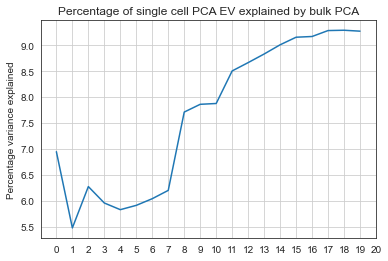

In [117]:
sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['varexpl']),Cumulative(magic_var_dict_hvgs['EV_upperbound']))])
plt.xticks(range(21))
plt.grid()
plt.title('Percentage of single cell PCA EV explained by bulk PCA')
plt.ylabel('Percentage variance explained')
plt.show()

In [118]:
# Average for different numbers of PCs
EV_ratios = [i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['varexpl']),Cumulative(magic_var_dict_hvgs['EV_upperbound']))]
np.average(EV_ratios)

0.0766347033556872

In [119]:
EV_ratios[6]

0.06040585244490473

In [120]:
#SEM for EV
n_components = 20
np.std(EV_ratios)/np.sqrt(n_components)

0.003109214892839983

In [121]:
random_ave_expl = []
for q in range(n_shuffles):
    random_ave_expl.append([i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][q]),
                 Cumulative(magic_var_dict_hvgs['EV_upperbound']))][6])


In [122]:
np.average([100*i for i in random_ave_expl])

0.2800992911516404

In [123]:
np.std([100*i for i in random_ave_expl])/np.sqrt(n_shuffles)

0.007836284476822556

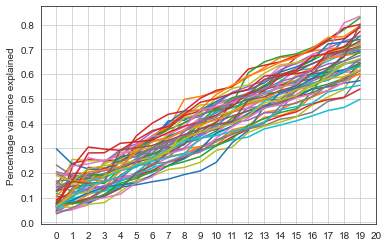

In [124]:
for i in range(n_shuffles):
    sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][i]),Cumulative(magic_var_dict_hvgs['EV_upperbound']))])
plt.xticks(range(21))
plt.grid()
plt.ylabel('Percentage variance explained')

plt.show()

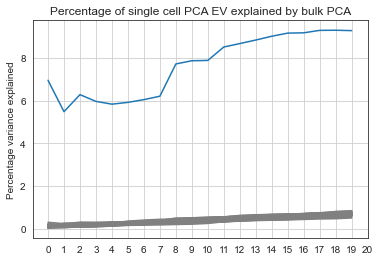

In [125]:
sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['varexpl']),Cumulative(magic_var_dict_hvgs['EV_upperbound']))])
for i in range(n_shuffles):
    sns.lineplot(range(20),[100*i/j for i, j in zip(Cumulative(magic_var_dict_hvgs['shuffled_fit_EV'][i]),Cumulative(magic_var_dict_hvgs['EV_upperbound']))],
                color = 'grey')
plt.xticks(range(21))
plt.grid()
plt.title('Percentage of single cell PCA EV explained by bulk PCA')
plt.ylabel('Percentage variance explained')
plt.savefig('../../figures/human-tumors-magic_pca_hvgs_in_arc_space_EV_of_scEV.pdf')

plt.show()

In [128]:
adata.write_h5ad('../../out/human-tumors/adata_02.h5ad')
X_magic.write_h5ad('../../out/human-tumors/X_magic_02.h5ad')

# Comparing single cell and bulk archetypes

<AxesSubplot:xlabel='0', ylabel='1'>

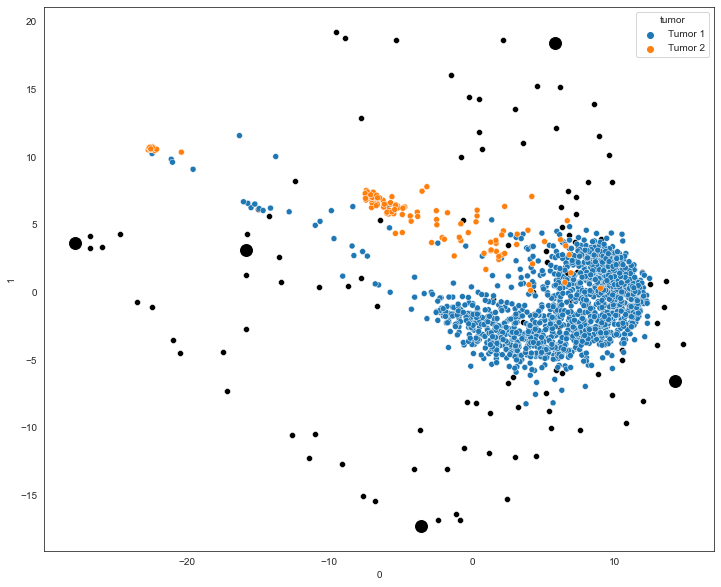

In [129]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'black')
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
sns.scatterplot(-magic_pca_df_hvgs[0], magic_pca_df_hvgs[1], hue =  X_magic.obs['tumor'])
# plt.savefig('../../figures/magic_pca_hvgs_in_arc_space.pdf')

## Read in single cell archetypes from ParetoTI - NOT DONE

In [597]:
arc_SC = pd.read_csv('../../out/cell-lines/ParetoTI/arc_single-fit-gene-space.csv', header = 0, index_col = 0)
arc_SC = arc_SC.loc[shared_genes]
arc_SC = pd.DataFrame(pp.scale(arc_SC), columns = arc_SC.columns, index = arc_SC.index)

# arc = arc / np.linalg.norm(arc, axis=0)

arc_SC_pca = pca.transform(arc_SC.T)
arc_SC_pca_df = pd.DataFrame(arc_SC_pca, index=arc_SC.columns)
arc_SC_pca_df['color'] = arc_SC.columns

In [633]:
arc_SC_pca_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,color
V1,23.321779,-20.343563,-9.119476,5.997457,-1.210913,-9.201368,0.692674,7.452336,-2.282247,9.987762,...,-3.197043,-7.404461,-9.291759,8.713745,2.687127,-2.967019,2.639380,-2.213255,3.236240,V1
V2,33.393801,7.868027,-0.350102,-17.013192,6.322770,1.435254,7.611478,5.429102,-4.897437,-9.716318,...,3.761046,0.862369,2.987612,1.007023,-3.233825,5.852210,0.079167,2.706874,-1.819045,V2
V3,-8.524098,-4.470536,-9.523606,-10.188685,15.141608,17.755382,-4.218019,-3.879835,-4.548606,-3.805362,...,5.912309,-12.776759,3.487675,11.323058,-3.056822,5.968342,-3.700584,-1.059878,-1.255037,V3
V4,-3.618371,30.945932,-12.050173,9.911831,-0.513443,-11.633153,-2.050840,-3.975935,-0.113145,-2.969665,...,9.762778,-3.417652,10.182152,-3.768732,-9.247831,-5.217795,5.860897,-2.786103,6.346264,V4


<AxesSubplot:xlabel='0', ylabel='1'>

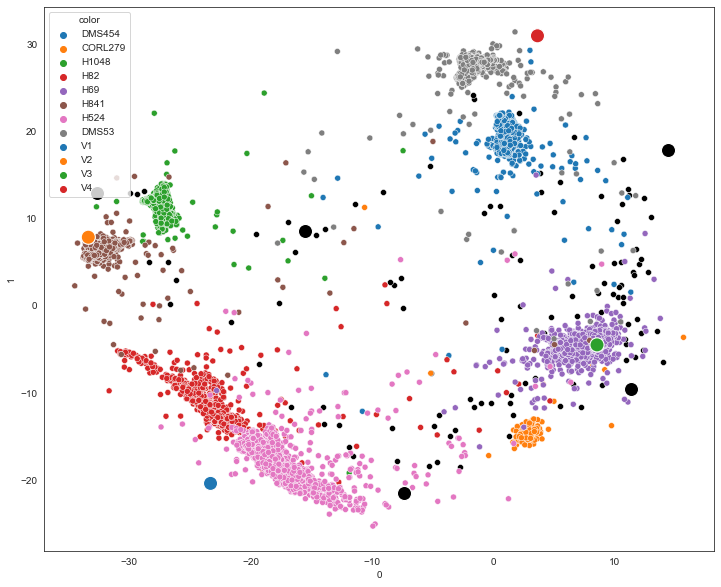

In [637]:
plt.figure(figsize = (12,10))
sns.scatterplot(-pca_df[0], pca_df[1], color = 'black')
sns.scatterplot(-magic_pca_df_hvgs[0], magic_pca_df_hvgs[1], hue =  X_magic.obs['cline'])
sns.scatterplot(-arc_pca_df[0], arc_pca_df[1], color = 'k', s = 200)
sns.scatterplot(data = arc_SC_pca_df, x = -arc_SC_pca_df[0], y = arc_SC_pca_df[1], hue ='color', s = 200)



In [629]:
tmp_df = arc_SC_pca_df.append(arc_pca_df).T.drop('color').astype(float)

tmp_df.corr()

In [640]:
arc = pd.read_csv('../../../data/bulk-rna-seq/arc_gene_space_no_lowgenes-10-21-20.csv', header = None, index_col = None)
arc_genes = pd.read_csv('../../../data/bulk-rna-seq/geneNames_wo_lowgenes.csv', header = None, index_col = None)
arc.columns = arc_genes[0]
arc = arc.T
arc.columns = ['SCLC-Y','SCLC-P','SCLC-N', 'SCLC-A2', 'SCLC-A']
arc = arc.loc[shared_genes]
arc = pd.DataFrame(pp.scale(arc), columns = arc.columns, index = arc.index)

In [648]:
tmp_df = arc_SC.T.append(arc.T).T.astype(float)



In [652]:
tmp_df.corr(method='spearman').style.background_gradient('viridis')

,V1,V2,V3,V4,SCLC-Y,SCLC-P,SCLC-N,SCLC-A2,SCLC-A
V1,1.000000,0.135881,0.020466,-0.335567,0.026699,0.064222,0.263449,-0.195405,0.039890
V2,0.135881,1.000000,-0.067021,-0.211235,0.409269,0.109635,0.016591,-0.154053,-0.061803
V3,0.020466,-0.067021,1.000000,-0.118222,-0.046123,0.041926,0.241714,0.234921,0.331292
V4,-0.335567,-0.211235,-0.118222,1.000000,0.018691,0.186789,-0.103127,0.353610,0.040258
SCLC-Y,0.026699,0.409269,-0.046123,0.018691,1.000000,0.689905,0.568055,0.531722,0.515107
SCLC-P,0.064222,0.109635,0.041926,0.186789,0.689905,1.000000,0.665018,0.698673,0.687042
SCLC-N,0.263449,0.016591,0.241714,-0.103127,0.568055,0.665018,1.000000,0.626108,0.827267
SCLC-A2,-0.195405,-0.154053,0.234921,0.353610,0.531722,0.698673,0.626108,1.000000,0.810789
SCLC-A,0.039890,-0.061803,0.331292,0.040258,0.515107,0.687042,0.827267,0.810789,1.000000


### Test likelihood of distance from single cell archetypes to bulk by random chance

### Test likelihood of corr between single cell archetypes and bulk by random chance